# Regularization: L1 and L2 for regression

Regularization is an important topic in modern regression, and in machine learning in general. It formalizes a tradeoff between fitting your training data and complexity (or: the tradeoff between within sample and out of sample fit) in a single objective. As we'll see with L1 regularization, it does a little more than that, adding parsimony as an additional way to control for overfitting.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO


Today, we will keep things fake and use simulated data. 

Why? 

We'll see later, but in the investigations that follow it is better to know the true model (that is, the true relationship between X and Y) we are trying to recover with our estimation procedures.

In [2]:
# some helper functions we will need for making the data
def make_independent_data(dimension=3, n=1000):
    '''
    Makes independent data in "dimension" dimensions
    '''
    covar = np.diag([10 / float( (i + 1) ** 2) for i in range(dimension)])
    dat_i = np.random.multivariate_normal([0 for i in range(dimension)], 
                                          covar, n)
    
    return dat_i

def make_correlated_data(dimension, phi=0.5, n=1000):
    '''
    Makes dependent data in "dimension" dimensions, correlation between
    index-adjacent dimensions controlled with "phi"
    NOTE: Phi must be between 0 and 1
    '''
    dat_i = make_independent_data(dimension, n)
    
    diag_D = np.concatenate([[1], [1 / np.sqrt(1 - phi**2) for i in range(dimension - 1)]])
    D = np.diag(diag_D)

    fc_L = np.concatenate([[1, phi], [0 for i in range(dimension-2)]])
    fr_L = np.concatenate([[1], [0 for i in range(dimension-1)]])

    L = sp.linalg.toeplitz(fc_L, fr_L)
    S = np.dot(D, L)
    
    dat_rotated = np.dot(dat_i, S)
    
    return dat_rotated



In [3]:
n_data_points = 600
n_features = 10
n_noise_features = 20

# the following parameter, phi controls how correlated the features are with each other; 
# note that this implies that some signal features will be correlated with noise features
phi = 0.2

true_linear_model = np.concatenate((np.random.normal(size=n_features) + 0.3, 
                                    np.zeros(n_noise_features)))

true_linear_model = np.reshape(np.array(true_linear_model), 
                               newshape=(n_features+n_noise_features, 1))

print 'Here are the true set of linear coefficients for this regression problem:\n'
print true_linear_model

print '\nNote that some feautres have a zero coefficient; they are extra and should'
print 'not be used, but we do not know that in our analysis'

# make the data now
X = make_correlated_data(n_features + n_noise_features, phi, n_data_points)

# use the features and the coefficients to make the data
Y_signal = np.dot(X, true_linear_model)
Y_noise = np.reshape(np.random.normal(size=n_data_points), newshape=(n_data_points, 1))
Y = np.add(Y_signal, Y_noise)
Y = Y.tolist()

train_data, train_labels = X[:350], Y[:350]
test_data, test_labels = X[350:], Y[350:]

Here are the true set of linear coefficients for this regression problem:

[[ 1.29444638]
 [ 0.62094893]
 [ 0.29416916]
 [-0.70675188]
 [ 1.59308653]
 [ 0.16285349]
 [ 0.22665462]
 [ 0.24892781]
 [ 0.85408762]
 [ 0.6719758 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]

Note that some feautres have a zero coefficient; they are extra and should
not be used, but we do not know that in our analysis


**Regularization in general**

Typical learning objectives simply optimizes the fit. It looks like (here beta are some parameters that define the model, say the coefficients in linear regression):

Objective(beta) = fit(beta)

And we do:

beta-hat = argmin(Objective(beta))

So, we choose the beta that minimizes the objective, that is, provides the best fit to the training data.

Regularization simply tweaks this by:

RegularizedObjective(beta) = fit(beta) + alpha * penalty(beta)

And, as above:

regularized-beta-hat = argmin(RegularizedObjective(beta))

So, what is the penalty? It is a way to define the complexity of beta. We'll see how complexity is defined below. But, in general, as the fit gets better, the complexity becomes higher, and so the objective nicely formalizes this tradeoff. Alpha is a constant (we'll have to pick it) that defines the strength of this tradeoff.

## L2 regularization: shrinkage

Let's explore the first type of regularization, L2 regularization. It takes the form:

Objective(beta) = fit(beta) + alpha * sum_j(beta_j^2)

Some useful docs for the following:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


In [11]:
lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

rm = Ridge(alpha=0.01, normalize=True)
rm.fit(train_data, train_labels)

rm_test_mse = ((rm.predict(test_data) - test_labels) ** 2).mean()

print rm.coef_.shape

print "Linear model test MSE:     ", lm_test_mse
print "Ridge regression test MSE: ", rm_test_mse

(1, 30)
Linear model test MSE:      1.11307636262
Ridge regression test MSE:  1.11000847914


Play with the alpha parameter, can you get a lower ridge regression test mse than linear model mse?

Now, let's see what happens to the coefficients as alpha changes. Here's an investigation for a single coefficient. What happens to other coefficients? How is this reducing complexity? You can also try out making a *regularization path plot*, see:

http://fa.bianp.net/blog/2011/ridge-regression-path/

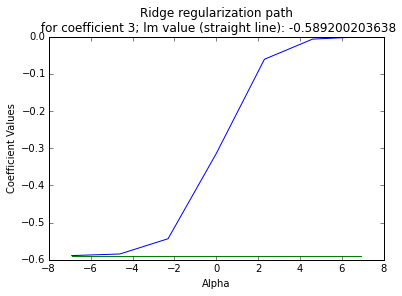

In [50]:
alpha_vec = [0.001, 0.01, .1, 1, 10, 100, 1000]
coef_idx = 3
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

for aa in enumerate(alpha_vec):
    lm = LinearRegression()
    lm.fit(train_data, train_labels)

    rm = Ridge(alpha=aa[1], normalize=True)
    rm.fit(train_data, train_labels)
    
    rm_coef = rm.coef_[0][coef_idx]
    lm_coef = lm.coef_[0][coef_idx]
 
    coef_values[aa[0]] = rm_coef
    lm_coef_line[aa[0]] = lm_coef
    
    
plt.plot(np.log(alpha_vec), coef_values)
plt.plot(np.log(alpha_vec), lm_coef_line)
plt.title('Ridge regularization path\n for coefficient ' + str(coef_idx) + '; lm value (straight line): ' + str(lm_coef)) 
plt.ylabel('Coefficient Values') 
plt.xlabel('Alpha') 
plt.show()

In [ ]:
import numpy as np
from scipy import linalg
def ridge(A, b, alphas):
    """
    Return coefficients for regularized least squares

         min ||A x - b||^2 + alpha ||x||^2

    Parameters
    ----------
    A : array, shape (n, p)
    b : array, shape (n,)
    alphas : array, shape (k,)

    Returns
    -------
    coef: array, shape (p, k)
    """
    U, s, Vt = linalg.svd(X, full_matrices=False)
    d = s / (s[:, np.newaxis].T ** 2 + alphas[:, np.newaxis])
    return np.dot(d * U.T.dot(y), Vt).T

### L1 Regularization: the lasso; shrinkage and selection

Let's explore another type of regularization, L1 regularization. It takes the form:

Objective(beta) = fit(beta) + alpha * sum_j(abs(beta_j))

Some useful docs for the following:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


In [51]:
lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

# try playing with the alpha
las = Lasso(alpha=0.0001, normalize=True)
las.fit(train_data, train_labels)

las_test_mse = ((las.predict(test_data) - test_labels) ** 2).mean()

print "Linear model test MSE: ", lm_test_mse
print "Lasso regression test MSE: ", las_test_mse

Linear model test MSE:  1.11307636262
Lasso regression test MSE:  49.3300325952


Play with the alpha parameter, can you get a lower lasso test mse than linear model mse?

Now, let's see what happens to the coefficients as alpha changes. Here's an investigation for a single coefficient. What happens to other coefficients? How is this reducing complexity?

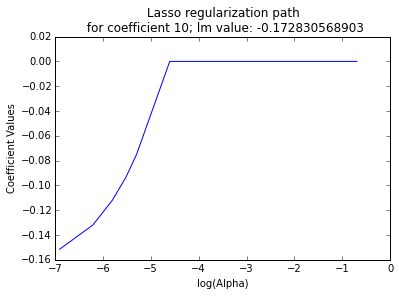

In [56]:
# you can try some more here...
alpha_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.1, 0.5]

# we pick a coefficient index, and we'll just look at this one
coef_idx = 10
coef_values = np.zeros(len(alpha_vec))

for aa in enumerate(alpha_vec):
    lm = LinearRegression()
    lm.fit(train_data, train_labels)

    las = Lasso(alpha=aa[1])
    las.fit(train_data, train_labels)

    las_coef = las.coef_[coef_idx]
    lm_coef = lm.coef_[0][coef_idx]
    
    coef_values[aa[0]] = las_coef
    
    #print lm_coef, rm_coef
    
plt.plot(np.log(alpha_vec), coef_values)
plt.title('Lasso regularization path\n for coefficient ' + str(coef_idx) + '; lm value: ' + str(lm_coef)) 
plt.ylabel('Coefficient Values') 
plt.xlabel('log(Alpha)') 
plt.show()


Something you should notice above is that the lasso sets coefficients to zero. There's a nice geometric interpretation of this fact, check out figure 3.12 here:

https://onlinecourses.science.psu.edu/stat857/node/158

Now that you know the lasso does *selection* as well as *shrinkage* (like ridge regression did), you can appreciate the original simulation.

Take a look back at the original data generation process. You'll see many of the features don't play any role in the true model. Can we get the lasso to drop those features?

Try the below code, can you get lasso to drop all those useless covariates? Do you need a high alpha? Or a low alpha?

Does dropping the useleess covariates improve the prediction properties of the model?

In [69]:
lm = LinearRegression()
lm.fit(train_data, train_labels)

las = Lasso(alpha=0.01, normalize=True)
las.fit(train_data, train_labels)

las_coef = las.coef_
lm_coef = lm.coef_[0.1]

# these are the indices of nonzero entries of the coefficient vector; which variables has the lasso dropped?
print 'index of nonzero linear regression variables: \n', np.where(lm_coef != 0)
print 'index of nonzero lasso variables: \n', np.where(las_coef != 0)

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()
las_test_mse = ((las.predict(test_data) - test_labels) ** 2).mean()

print "Linear model test MSE: ", lm_test_mse
print "Lasso regression test MSE: ", las_test_mse

index of nonzero linear regression variables: 
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),)
index of nonzero lasso variables: 
(array([0, 1, 2, 3, 4, 5, 6, 8, 9]),)
Linear model test MSE:  1.11307636262
Lasso regression test MSE:  46.7684794989
